# ハンズオン：Q＆A アプリケーション


In [1]:
# ====================================================
# ロールの定義
# ====================================================
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。",
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。",
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。",  # noqa: E501
    },
}


In [5]:
# ====================================================
# ステートの定義
# ====================================================
import operator
from typing import Annotated

# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(description="ユーザーからの質問")

    current_role: str = Field(default="", description="選定された回答ロール")

    messages: Annotated[list[str], operator.add] = Field(default=[], description="回答履歴")

    current_judge: bool = Field(default=False, description="品質チェックの結果")

    judgement_reason: str = Field(default="", description="品質チェックの判定理由")


In [6]:
# ====================================================
# Chat modelの初期化
# ====================================================
from langchain_core.runnables import ConfigurableField
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id="max_tokens"))


In [9]:
# ====================================================
# ノードの定義
# ====================================================

# selectionノードの実装
from typing import Any

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{role_id}: {role['name']}" for role_id, role in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
        """質問を分析し、最も適切な回答担当ロールを選択してください。

    選択肢：
    {role_options}

    回答は選択肢の番号（1、2、または3）のみを返してください。

    質問：{query}
    """.strip()
    )

    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})
    selected_role = ROLES[role_number.strip()]["name"]

    return {"current_role": selected_role}


In [16]:
# answeringノードの実装
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {value['name']}: {value['description']}" for value in ROLES.values()])

    prompts = ChatPromptTemplate.from_template(
        """
        あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

        役割の詳細：
        {role_details}

        質問：{query}

        回答：
        """.strip()
    )

    chain = prompts | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})

    return {"messages": [answer]}


In [17]:
# checkノードの実装
class Judgement(BaseModel):
    reason: str = Field(default="", description="判定理由")
    judge: bool = Field(default=False, description="判定結果")


def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]

    prompt = ChatPromptTemplate.from_template(
        """以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'と回答してください。
        またその判断理由も説明してください。

        ユーザーからの質問：{query}
        回答：{answer}
        """.strip()
    )

    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {"current_judge": result.judge, "judgement_reason": result.reason}


In [18]:
# ====================================================
# グラフの作成
# ====================================================
from langgraph.graph import StateGraph

workflow = StateGraph(State)


In [19]:
# ====================================================
# ノードの追加
# ====================================================
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)


In [22]:
# ====================================================
# エッジの定義
# ====================================================

# selectionノードから処理を開始
workflow.set_entry_point("selection")
# 下記の書き方でも可能
# from langgraph.graph import START
# workflow.add_edge(START, "selection")

# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

# ====================================================
# 条件付きエッジの定義
# ====================================================
from langgraph.graph import END  # noqa: E402

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeがTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges("check", lambda state: state.current_judge, {True: END, False: "selection"})

# ====================================================
# グラフのコンパイル
# ====================================================
compiled = workflow.compile()


In [36]:
# ====================================================
# グラフの実行
# ====================================================
initial_state = State(query="生成AIの今後の発展について教えてください。")
result = compiled.invoke(initial_state)


In [37]:
# 結果の表示
print(result["messages"][-1])


生成AI製品エキスパートとしてお答えします。

生成AIの今後の発展は非常に多岐にわたる可能性があります。まず、技術的な進歩として、モデルの精度と効率がさらに向上することが期待されています。これにより、より自然で人間らしいテキストや画像の生成が可能になるでしょう。

また、生成AIはさまざまな産業での応用が進むと考えられます。例えば、コンテンツ制作、カスタマーサポート、自動翻訳、医療診断、クリエイティブなデザインなど、多くの分野での活用が進むでしょう。特に、個別化されたユーザー体験の提供や、効率的なデータ分析の支援において重要な役割を果たすと予想されます。

さらに、倫理的な側面やプライバシーの問題に対する取り組みも重要です。生成AIの利用が広がる中で、フェイクニュースやデジタル著作権の問題などに対する対策が求められています。これに対して、透明性の向上や、AIの出力を検証するための新しい技術の開発が進むでしょう。

最後に、生成AIの民主化が進むことで、より多くの人々がこの技術を利用し、新しいアイデアやビジネスを生み出す機会が増えると考えられます。これにより、社会全体でのイノベーションが加速することが期待されます。


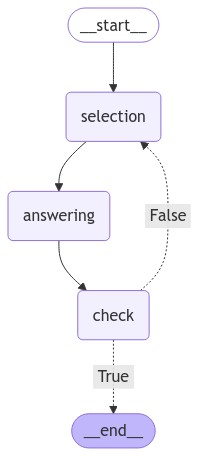

In [26]:
# ====================================================
# グラフの可視化
# ====================================================
from IPython.display import Image, display

# 本文中ではdraw_png関数を使用していたが、今回はpygraphvizをインストールしていないため、draw_mermaid_png関数を使用
display(Image(compiled.get_graph().draw_mermaid_png()))
